# Intersubject correlation
This notebook provides interactive examples of intersubject correlation (ISC) analysis using BrainIAK. When participants receive the same stimulus (e.g. an audiovisual movie or spoken story), part of their brain activity is driven by the stimulus and is thus shared across individuals. ISC analysis is a family of simple methods for measuring this shared, stimulus-driven response across subjects ([Hasson et al., 2004](https://doi.org/10.1126/science.1089506); [Nastase et al., 2019](https://doi.org/10.1093/scan/nsz037)). In the following, we compute ISC on an example story-listening dataset, then briefly touch on some extensions of ISC analysis. This notebook accompanies the manuscript "BrainIAK: The Brain Imaging Analysis Kit" by Kumar and colleagues (2020).

#### Outline
- [Example fMRI data and atlas](#Example-fMRI-data-and-atlas)
- [Computing intersubject correlation](#Computing-intersubject-correlation)
- [Temporal receptive windows](#Temporal-receptive-windows)
- [Intersubject network estimation](#Intersubject-network-estimation)
- [Intersubject pattern correlation](#Intersubject-pattern-correlation)

In [1]:
# Import necessary python modules
from glob import glob
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
from brainiak.isc import isc, isfc

### Example fMRI data and atlas
To explore ISC analysis, we use an fMRI dataset collected while participants listened to two versions of a spoken story called "[It's Not the Fall that Gets You](https://themoth.org/stories/its-not-the-fall-that-gets-you)" by Andy Christie. Participants either listened to the original version of the story (referred to as the *intact* condition) or a temporally scrambled version of the story (referred to as the *shortscram* condition). These data are available as part of the [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)) and were recently published in work by Chien and Honey ([2020](https://doi.org/10.1016/j.neuron.2020.02.013)). Here, we download a pre-packaged subset of the data from Zenodo. These data have been preprocessed using fMRIPrep and confound regression in AFNI. To reduce computational demands, we compute parcel-wise ISCs using a cortical parcellation containing 400 parcels from Schaefer and colleages ([2018](https://doi.org/10.1093/cercor/bhx179)).

In [2]:
# Download example fMRI data and atlas from Zenodo
intact_fns = sorted(glob('../../data/sub-*_task-notthefallintact_*bold.nii.gz'))
atlas_fn = '../../data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_3mm.nii.gz'

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# Load in intact functional data and compute parcel means
intact_parcels = []
for intact_fn in intact_fns:
    intact_data = nib.load(intact_fn).get_fdata()
    intact_means = [np.mean(intact_data[atlas_img == parcel, :], axis=0)
                    for parcel in np.unique(atlas_img)[1:]]
    intact_parcels.append(np.column_stack(intact_means))
intact_parcels = np.dstack(intact_parcels)

### Computing intersubject correlation
Next we compute leave-one-out ISCs on data from the *intact* condition for each parcel using BrainIAK's `isc` function. We average ISC values across subjects for visualization. This reveals high ISCs in superior temporal auditory cortex, as well as strong ISCs extending into higher level cortical areas, such as the precuneus and other nodes of the default-mode network. Here, we simply want to visualize ISC rather than perform a statistical test, so we threshold the maps at ISC > .10. BrainIAK provides several nonparametric statistical tests (e.g. `bootstrap_isc`, `phaseshift_isc`); for a more thorough statistical treatment, we refer readers to a series of papers by Chen and colleagues ([2016](https://doi.org/10.1016/j.neuroimage.2016.05.023), [2017](https://doi.org/10.1016/j.neuroimage.2016.08.029), [2020](https://doi.org/10.1016/j.neuroimage.2019.116474)).

In [3]:
# Compute parcel-wise ISC using the leave-one-out approach
intact_iscs = isc(intact_parcels, pairwise=False,
                  summary_statistic='mean')

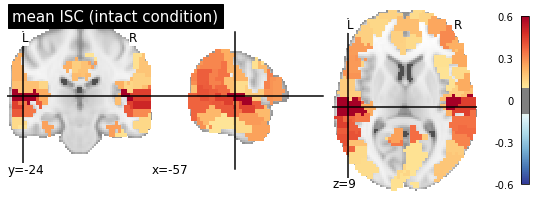

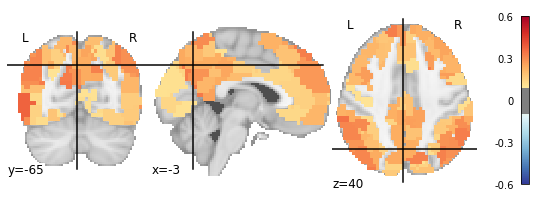

For the intact story stimulus, high parcel-wise ISC extends from low-level
auditory areas into higher-level areas including posterior medial cortex.


In [4]:
# Project intact parcel-wise ISC values onto brain
intact_img = np.zeros(atlas_img.shape)
for i, parcel in enumerate(np.unique(atlas_img)[1:]):
    intact_img[atlas_img == parcel] = intact_iscs[i]

# Convert to NIfTI image for visualization with Nilearn
intact_nii = nib.Nifti1Image(intact_img, atlas_nii.affine, atlas_nii.header)

# Plot intact ISCs to visualize superior temporal cortex
plot_stat_map(intact_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              title='mean ISC (intact condition)', cut_coords=(-57, -24, 9))

# Plot intact ISCs to visualize posterior medial cortex
plot_stat_map(intact_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              cut_coords=(-3, -65, 40));
plt.show()

# Print short "figure caption" describing result
print("For the intact story stimulus, high parcel-wise ISC extends "
      "from low-level\nauditory areas into higher-level areas "
      "including posterior medial cortex.")

## Temporal receptive windows
Next, we'll load in fMRI data for a temporally scrambled version of the same stimulus. We compute parcel-wise leave-one-out ISC in the same manner as for the *intact* stimulus. Temporally scrambling the stimulus retains many low-level perceptual qualities of the stimulus, but abolishes the higher-level semantic meaning and narrative arc. Correspondingly, we see high ISC in early auditory cortex (similar to the *intact* condition), but markedly lower ISC in high-level cortices than observed with the *intact* stimulus.

In [5]:
# Load in scrambled functional data and compute parcel means
scram_fns = sorted(glob('../../data/sub-*_task-notthefallshortscram_*bold.nii.gz'))
scram_parcels = []
for scram_fn in scram_fns:
    scram_data = nib.load(scram_fn).get_fdata()
    scram_means = [np.mean(scram_data[atlas_img == parcel, :], axis=0)
                   for parcel in np.unique(atlas_img)[1:]]
    scram_parcels.append(np.column_stack(scram_means))
scram_parcels = np.dstack(scram_parcels)

In [6]:
# Compute parcel-wise ISC using the leave-one-out approach
scram_iscs = isc(scram_parcels, pairwise=False,
                 summary_statistic='mean')

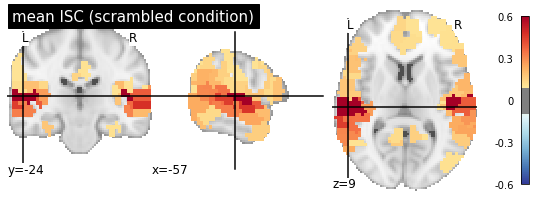

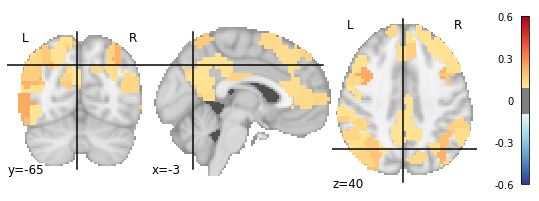

For the scrambled story stimulus, we observe high ISC in early auditory
areas, but reduced ISC in higher-level areas like posterior medial cortex.


In [7]:
# Project parcel-wise ISC values onto brain
scram_img = np.zeros(atlas_img.shape)
for i, parcel in enumerate(np.unique(atlas_img)[1:]):
    scram_img[atlas_img == parcel] = scram_iscs[i]

# Convert to a NIfTI image for visualization with Nilearn
scram_nii = nib.Nifti1Image(scram_img, atlas_nii.affine, atlas_nii.header)

# Plot scrambled ISCs to visualize superior temporal cortex
plot_stat_map(scram_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              title='mean ISC (scrambled condition)',
              cut_coords=(-57, -24, 9))

# Plot scrambled ISCs to visualize posterior medial cortex
plot_stat_map(scram_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              cut_coords=(-3, -65, 40));
plt.show()

# Print short "figure caption" describing result
print("For the scrambled story stimulus, we observe high ISC "
      "in early auditory\nareas, but reduced ISC in higher-level "
      "areas like posterior medial cortex.")

## Intersubject network estimation
Instead of only computing ISC between homologous brain areas, we can also compute ISC across brain areas using intersubject functional correlation (ISFC) analysis ([Simony et al., 2016](https://doi.org/10.1038/ncomms12141)). Traditional functional connectivity (FC) analyses measure within-subject FC, typically during resting-state paradigms.  ISFC analysis, on the other hand measures shared stimulus-evoked functional connectivity. Traditional FC analyses are highly sensitive to artefacts such as head motion or physiological. Unlike within-subject FC, ISFC analysis filters out artefacts that are not synchronized across subjects.

In [8]:
# Compute ISFC on intact data
intact_isfcs = isfc(intact_parcels, pairwise=False,
                    vectorize_isfcs=False,
                    summary_statistic='mean')

# Compute ISFC on scrambled data
scram_isfcs = isfc(scram_parcels, pairwise=False,
                   vectorize_isfcs=False,
                   summary_statistic='mean')

In [9]:
# Compute mean with Fisher z-transformation
def fisher_mean(correlation, axis=None):
    return np.tanh(np.mean(np.arctanh(correlation), axis=axis))

# Compute within-subject functional connectivity for intact data
intact_fcs = fisher_mean([np.corrcoef(s) for s in intact_parcels.T],
                         axis=0)

# Compute within-subject functional connectivity for scrambled data
scram_fcs = fisher_mean([np.corrcoef(s) for s in scram_parcels.T],
                        axis=0)

/Users/snastase/miniconda3/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Load in network labels
label_fn = '../../data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

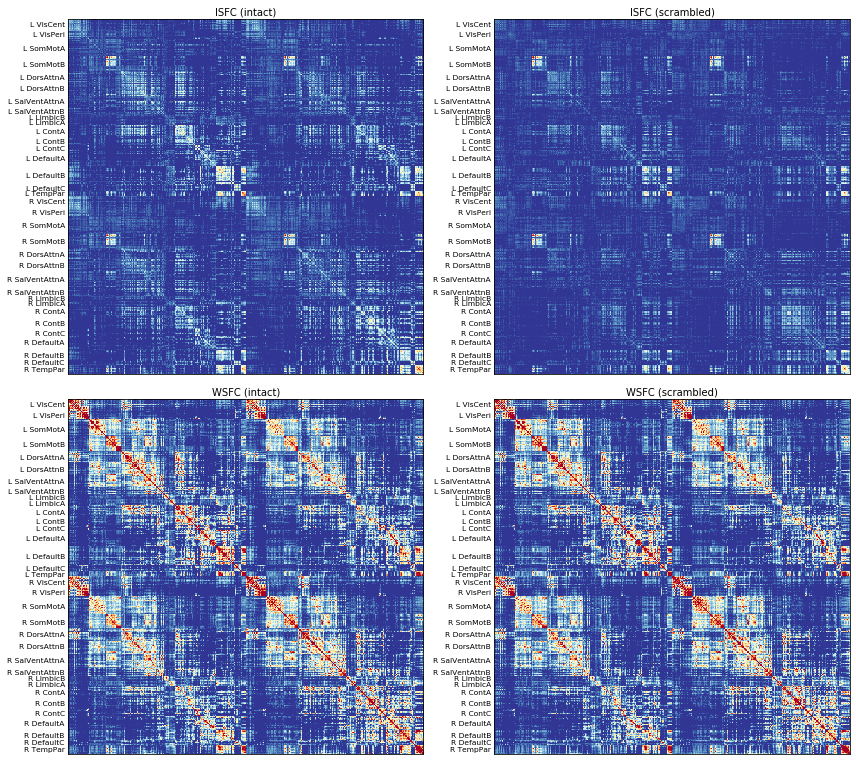

ISFC networks have generally lower correlations that within-subject functional connectivity, but better
differentiate intact and scrambled stories.

Correlation between intact and scrambled ISFC networks: 0.619
Correlation between intact and scrambled WSFC networks: 0.945


In [11]:
# Visualize ISFC/FC matrices for intact and scrambled conditions
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
fc_mats = [intact_isfcs, scram_isfcs, intact_fcs, scram_fcs]
fc_titles = ['ISFC (intact)', 'ISFC (scrambled)',
             'WSFC (intact)', 'WSFC (scrambled)']
for ax, fc, t in zip(axs.flatten(), fc_mats, fc_titles):
    ax.matshow(fc, vmax=.5, vmin=0, cmap='RdYlBu_r')
    ax.set_xlabel(t)
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks(network_idxs)
    ax.set_yticklabels(network_labels)
    ax.tick_params(axis='y', which='both', length=0, labelsize=7.5)
plt.subplots_adjust(hspace=0)
plt.show()

# High correlation between intact and scrambled
# for within-subject functional connectivity
fc_r = pearsonr(squareform(intact_fcs, checks=False),
                squareform(scram_fcs, checks=False))[0]

# ISFC is more distinct for intact and scrambed conditions
isfc_r = pearsonr(squareform(intact_isfcs, checks=False),
                  squareform(scram_isfcs, checks=False))[0]

print("ISFC networks have generally lower correlations that "
      "within-subject functional connectivity, but better\n"
      "differentiate intact and scrambled stories.\n")
print(f"Correlation between intact and scrambled ISFC networks: {isfc_r:.3}")
print(f"Correlation between intact and scrambled WSFC networks: {fc_r:.3}")

## Intersubject pattern correlation
Rather than computing parcel-wise ISC across time, we can compute the spatial ISC of distributed response patterns in a parcel (e.g. [Chen et al., 2017](https://doi.org/10.1038/nn.4450), [Zadbood et al., 2017](https://doi.org/10.1093/cercor/bhx202)). Computing intersubject pattern correlation across all time points can allow us to discover whether similar response patterns recur at different points in the stimulus ([Baldassano et al., 2017](https://doi.org/10.1016/j.neuron.2017.06.041)). Here, we compute ISPC for the left default-mode network (DMN) A network.

In [12]:
# Get labels for parcels in left DMN A network
dmn_a = (np.array(networks) == 'L DefaultA').nonzero()[0] + 1

# Re-load in intact functional data and extract DMN A
intact_dmns = []
for intact_fn in intact_fns:
    intact_data = nib.load(intact_fn).get_fdata()
    intact_dmns.append(np.column_stack([intact_data[atlas_img == parcel, :].T
                                        for parcel in dmn_a]))
intact_dmns = np.dstack(intact_dmns)

# Load in scrambled functional data and extract DMN A
scram_dmns = []
for scram_fn in scram_fns:
    scram_data = nib.load(scram_fn).get_fdata()
    scram_dmns.append(np.column_stack([scram_data[atlas_img == parcel, :].T
                                       for parcel in dmn_a]))
scram_dmns = np.dstack(scram_dmns)

In [13]:
# Transpose input data to compute intersubject pattern correlation
intact_ispcs = isfc(np.rollaxis(intact_dmns, 1, 0),
                    pairwise=False, vectorize_isfcs=False,
                    summary_statistic='mean')

scram_ispcs = isfc(np.rollaxis(scram_dmns, 1, 0),
                   pairwise=False, vectorize_isfcs=False,
                   summary_statistic='mean')

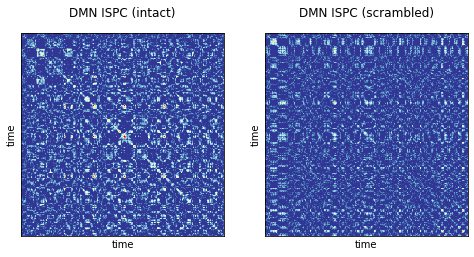

In [14]:
# Plot intersubject pattern correlation for intact and scrambled story stimuli
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
ispcs = [intact_ispcs, scram_ispcs]
titles = ['DMN ISPC (intact)', 'DMN ISPC (scrambled)']
for ax, ispc, t in zip(axs, ispcs, titles):
    ax.matshow(ispc, vmax=.15, vmin=0, cmap='RdYlBu_r')
    ax.set_title(t) 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('time')
    ax.set_ylabel('time')

## Summary
Using ISC analysis, we are able to measure shared responses to a complex story stimulus. By comparing ISC for brain responses to the intact and temporally-scrambled story stimulus, we can identify areas of the brain sensitive to temporally-evolving features of the stimulus (e.g. narrative context). ISFC analysis allows us examine functional network organization in a way that is more sensitive to the stimulus than traditional within-subject functional connectivity analysis. Finally, we can apply the logic of ISC analysis to distributed responses patterns to visualizing recurring response patterns over time.

#### References
* Baldassano, C., Chen, J., Zadbood, A., Pillow, J. W., Hasson, U., & Norman, K. A. (2017). Discovering event structure in continuous narrative perception and memory. *Neuron*, *95(3), 709-721. https://doi.org/10.1016/j.neuron.2017.06.041

* Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: nonparametric approaches to inter-subject correlation analysis at the group level. *NeuroImage*, *142*, 248-259. https://doi.org/10.1016/j.neuroimage.2016.05.023

* Chen, G., Taylor, P. A., Shin, Y. W., Reynolds, R. C., & Cox, R. W. (2017). Untangling the relatedness among correlations, part II: inter-subject correlation group analysis through linear mixed-effects modeling. *NeuroImage*, *147*, 825-840. https://doi.org/10.1016/j.neuroimage.2016.08.029

* Chen, G., Taylor, P. A., Qu, X., Molfese, P. J., Bandettini, P. A., Cox, R. W., & Finn, E. S. (2020). Untangling the relatedness among correlations, part III: inter-subject correlation analysis through Bayesian multilevel modeling for naturalistic scanning. *NeuroImage*, *216*, 116474. https://doi.org/10.1016/j.neuroimage.2019.116474

* Chen, J., Leong, Y. C., Honey, C. J., Yong, C. H., Norman, K. A., & Hasson, U. (2017). Shared memories reveal shared structure in neural activity across individuals. *Nature Neuroscience*, *20*(1), 115-125. https://doi.org/10.1038/nn.4450

* Chien, H. Y. S., & Honey, C. J. (2020). Constructing and forgetting temporal context in the human cerebral cortex. *Neuron*, *106*(4), 675-686. https://doi.org/10.1016/j.neuron.2020.02.013

* Hasson, U., Nir, Y., Levy, I., Fuhrmann, G., & Malach, R. (2004). Intersubject synchronization of cortical activity during natural vision. *Science*, *303*(5664), 1634–1640. https://doi.org/10.1126/science.1089506

* Nastase, S. A., Gazzola, V., Hasson, U., & Keysers, C. (2019). Measuring shared responses across subjects using intersubject correlation. *Social Cognitive and Affective Neuroscience*, *14*(6), 667–685. https://doi.org/10.1093/scan/nsz037

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2019). Narratives: fMRI data for evaluating models of naturalistic language comprehension. *OpenNeuro*, ds002345. https://doi.org/10.18112/openneuro.ds002345.v1.1.2

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., Eickhoff, S. B., & Yeo, B. T. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. *Cerebral Cortex*, *28*(9), 3095-3114. https://doi.org/10.1093/cercor/bhx179

* Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., & Hasson, U. (2016). Dynamic reconfiguration of the default mode network during narrative comprehension. *Nature Communications*, *7*, 12141. https://doi.org/10.1038/ncomms12141

* Zadbood, A., Chen, J., Leong, Y. C., Norman, K. A., & Hasson, U. (2017). How we transmit memories to other brains: constructing shared neural representations via communication. *Cerebral Cortex*, *27*(10), 4988-5000. https://doi.org/10.1093/cercor/bhx202